In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_74.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_64.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_60.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_22.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_7.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_85.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_49.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_50.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_79.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_89.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_97.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/riped/riped_tomato_58.jpeg
/kaggle/input/tomato-dataset-full/data/labeled-data/r

# SSL Method - Mean Teacher to predict ripeness of tomatoes

- ResNet
- Dropout
- L2 Regularization
- Learning Rate Scheduler

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
from copy import deepcopy
from tqdm import tqdm
from PIL import Image

In [3]:
seed = 1

# Set device to use GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
else: 
    device = torch.device('cpu')

torch.manual_seed(seed)

print(device)

cuda


In [4]:
# Enforce deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
# DataLoader with worker_init_fn to ensure different seeds for each worker
def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)
    torch.manual_seed(seed + worker_id)

## Data Setup

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Load labeled datasets
labeled_data_dir = '/kaggle/input/tomato-dataset-full/data/labeled-data'
labeled_dataset = datasets.ImageFolder(labeled_data_dir, transform=transform)

In [8]:
# Split labeled data into training and testing datasets
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = random_split(labeled_dataset, [train_size, test_size])

In [9]:
# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

print('Num Labeled: ', len(labeled_dataset))

Num Labeled:  177


In [10]:
# Custom dataset class for unlabeled data
class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir) if img.endswith('.jpg') or img.endswith('.png')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [11]:
# Load unlabeled datasets
unlabeled_data_dir = '/kaggle/input/tomato-dataset-full/data/unlabeled-data'
unlabeled_dataset = UnlabeledDataset(unlabeled_data_dir, transform=transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)

print('Num Unlabeled: ', len(unlabeled_dataset))

Num Unlabeled:  996


## Define Model

In [12]:
# Define the ResNet model with dropout
class ResNetModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Initialize the models
student_model = ResNetModel(num_classes=2).to(device)
teacher_model = ResNetModel(num_classes=2).to(device)
teacher_model.load_state_dict(student_model.state_dict())

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s] 


<All keys matched successfully>

## Train Model

In [14]:
def update_teacher_model(student_model, teacher_model, alpha=0.99):
    for teacher_params, student_params in zip(teacher_model.parameters(), student_model.parameters()):
        teacher_params.data.mul_(alpha).add_(student_params.data, alpha=1-alpha)

In [15]:
def mean_teacher_train(student_model, teacher_model, train_loader, unlabeled_loader, test_loader, criterion, optimizer, scheduler, num_epochs=35, consistency_weight=1.0):
    best_model_wts = deepcopy(student_model.state_dict())
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    train_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    test_accuracy = torchmetrics.Accuracy(task='binary').to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        
        # Training phase
        student_model.train()
        running_loss = 0.0
        train_accuracy.reset()
        
        labeled_iter = iter(train_loader)
        unlabeled_iter = iter(unlabeled_loader)
        
        for i in range(len(train_loader)):
            try:
                labeled_inputs, labeled_labels = next(labeled_iter)
            except StopIteration:
                break

            try:
                unlabeled_inputs = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                unlabeled_inputs = next(unlabeled_iter)

            labeled_inputs, labeled_labels = labeled_inputs.to(device), labeled_labels.to(device)
            unlabeled_inputs = unlabeled_inputs.to(device)

            # Forward pass for labeled data
            optimizer.zero_grad()
            labeled_outputs = student_model(labeled_inputs)
            labeled_loss = criterion(labeled_outputs, labeled_labels)

            # Forward pass for unlabeled data
            with torch.no_grad():
                teacher_outputs = teacher_model(unlabeled_inputs)
                teacher_probs = torch.softmax(teacher_outputs, dim=1)
                max_probs, pseudo_labels = torch.max(teacher_probs, dim=1)

            student_outputs = student_model(unlabeled_inputs)
            consistency_loss = nn.CrossEntropyLoss()(student_outputs, pseudo_labels)
            loss = labeled_loss + consistency_weight * consistency_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update teacher model
            update_teacher_model(student_model, teacher_model)

            # Update training metrics
            preds = torch.argmax(labeled_outputs, dim=1)
            train_accuracy.update(preds, labeled_labels)
            running_loss += loss.item() * labeled_inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = train_accuracy.compute().item()
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        # Validation phase
        student_model.eval()
        running_loss = 0.0
        test_accuracy.reset()
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validation', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student_model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)
                test_accuracy.update(preds, labels)
                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = test_accuracy.compute().item()
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'Validation Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = deepcopy(student_model.state_dict())

    student_model.load_state_dict(best_model_wts)
    return student_model, train_losses, test_losses, train_accuracies, test_accuracies

In [16]:
# Instantiate model, loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001, weight_decay=1e-4)  # Add L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [17]:
# Train and evaluate the model using Mean Teacher method
mean_teacher_model, train_losses, test_losses, train_accuracies, test_accuracies = mean_teacher_train(
    student_model, teacher_model, train_loader, unlabeled_loader, test_loader, criterion, optimizer, scheduler)

Epoch 1/35
Training Loss: 1.5304 Acc: 0.7801


Validation Loss: 1.1867 Acc: 0.8056
Epoch 2/35


Training Loss: 1.2488 Acc: 0.8652


Validation Loss: 1.5163 Acc: 0.5000
Epoch 3/35


Training Loss: 0.9058 Acc: 0.9007


Validation Loss: 0.6132 Acc: 0.8611
Epoch 4/35


Training Loss: 0.8405 Acc: 0.9220


Validation Loss: 0.6749 Acc: 0.5833
Epoch 5/35


Training Loss: 0.6808 Acc: 0.9574


Validation Loss: 0.0812 Acc: 1.0000
Epoch 6/35


Training Loss: 0.4553 Acc: 0.9574


Validation Loss: 0.0642 Acc: 1.0000
Epoch 7/35


Training Loss: 0.5803 Acc: 0.9645


Validation Loss: 0.2352 Acc: 0.8889
Epoch 8/35


Training Loss: 0.4630 Acc: 0.9504


Validation Loss: 0.0196 Acc: 1.0000
Epoch 9/35


Training Loss: 0.5838 Acc: 0.9291


Validation Loss: 0.2767 Acc: 0.9167
Epoch 10/35


Training Loss: 0.4394 Acc: 0.9574


Validation Loss: 0.0087 Acc: 1.0000
Epoch 11/35


Training Loss: 0.3566 Acc: 0.9645


Validation Loss: 0.0091 Acc: 1.0000
Epoch 12/35


Training Loss: 0.2493 Acc: 0.9787


Validation Loss: 0.0069 Acc: 1.0000
Epoch 13/35


Training Loss: 0.2071 Acc: 0.9787


Validation Loss: 0.0049 Acc: 1.0000
Epoch 14/35


Training Loss: 0.2185 Acc: 0.9787


Validation Loss: 0.0034 Acc: 1.0000
Epoch 15/35


Training Loss: 0.2096 Acc: 0.9787


Validation Loss: 0.0041 Acc: 1.0000
Epoch 16/35


Training Loss: 0.2413 Acc: 0.9645


Validation Loss: 0.0021 Acc: 1.0000
Epoch 17/35


Training Loss: 0.1787 Acc: 0.9858


Validation Loss: 0.0013 Acc: 1.0000
Epoch 18/35


Training Loss: 0.1413 Acc: 0.9929


Validation Loss: 0.0013 Acc: 1.0000
Epoch 19/35


Training Loss: 0.1710 Acc: 0.9787


Validation Loss: 0.0014 Acc: 1.0000
Epoch 20/35


Training Loss: 0.1470 Acc: 0.9787


Validation Loss: 0.0011 Acc: 1.0000
Epoch 21/35


Training Loss: 0.1345 Acc: 0.9716


Validation Loss: 0.0011 Acc: 1.0000
Epoch 22/35


Training Loss: 0.1755 Acc: 0.9716


Validation Loss: 0.0011 Acc: 1.0000
Epoch 23/35


Training Loss: 0.1269 Acc: 0.9929


Validation Loss: 0.0009 Acc: 1.0000
Epoch 24/35


Training Loss: 0.1285 Acc: 0.9787


Validation Loss: 0.0013 Acc: 1.0000
Epoch 25/35


Training Loss: 0.1771 Acc: 0.9858


Validation Loss: 0.0008 Acc: 1.0000
Epoch 26/35


Training Loss: 0.1018 Acc: 0.9858


Validation Loss: 0.0009 Acc: 1.0000
Epoch 27/35


Training Loss: 0.1389 Acc: 0.9858


Validation Loss: 0.0010 Acc: 1.0000
Epoch 28/35


Training Loss: 0.0928 Acc: 0.9929


Validation Loss: 0.0010 Acc: 1.0000
Epoch 29/35


Training Loss: 0.0933 Acc: 0.9858


Validation Loss: 0.0008 Acc: 1.0000
Epoch 30/35


Training Loss: 0.1096 Acc: 0.9716


Validation Loss: 0.0008 Acc: 1.0000
Epoch 31/35


Training Loss: 0.1486 Acc: 0.9716


Validation Loss: 0.0008 Acc: 1.0000
Epoch 32/35


Training Loss: 0.1191 Acc: 0.9787


Validation Loss: 0.0008 Acc: 1.0000
Epoch 33/35


Training Loss: 0.1084 Acc: 0.9858


Validation Loss: 0.0008 Acc: 1.0000
Epoch 34/35


Training Loss: 0.1899 Acc: 0.9645


Validation Loss: 0.0007 Acc: 1.0000
Epoch 35/35


Training Loss: 0.1275 Acc: 0.9787


Validation Loss: 0.0008 Acc: 1.0000


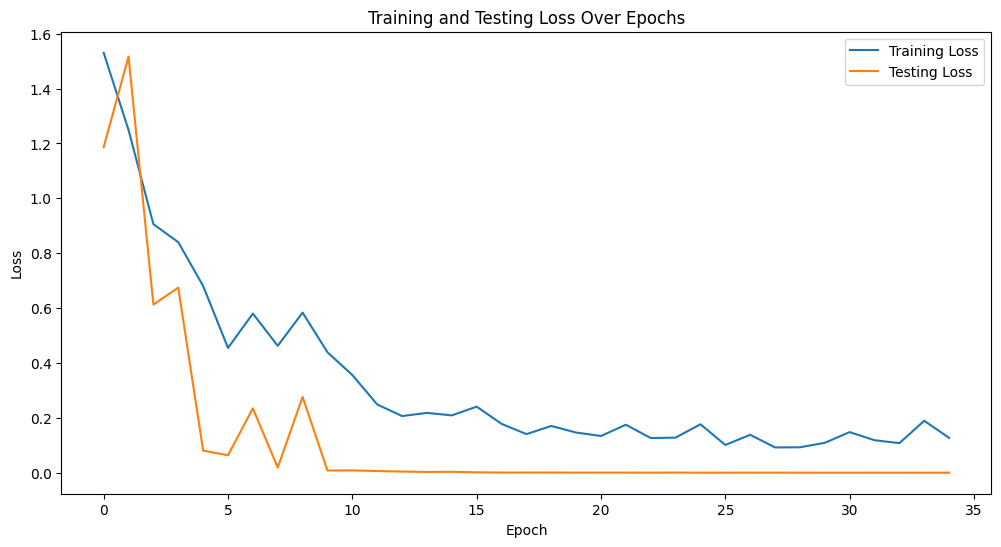

In [18]:
# Plot training and testing loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Over Epochs')
plt.show()

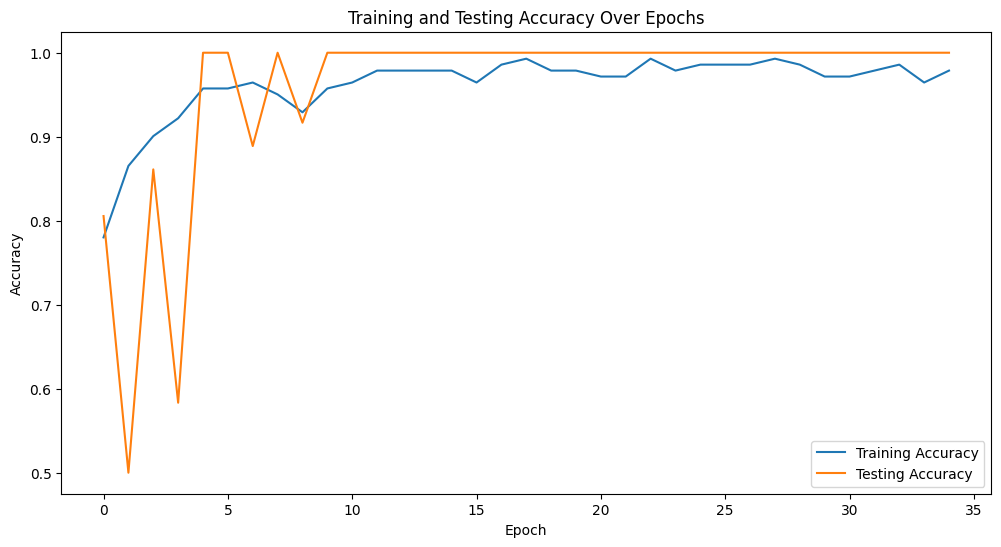

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy Over Epochs')
plt.show()

## Validate

In [20]:
# Evaluate on validation set
validation_dir = '/kaggle/input/tomato-dataset-full/data/validation-data'
validation_dataset = datasets.ImageFolder(validation_dir, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, num_workers=4, worker_init_fn=worker_init_fn)

print('Validation Dataset Size: ', len(validation_dataset))

Validation Dataset Size:  2000


In [21]:
# Evaluate on validation set and display images
def evaluate_and_display(model, validation_loader, num_images=16):
    model.eval()
    val_accuracy = torchmetrics.Accuracy(task='binary').to(device)
    all_labels, all_preds, all_probs = [], [], []
    images = []
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            val_accuracy.update(preds, labels)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            images.extend(inputs.cpu())
            num_samples += len(labels)

    val_acc = val_accuracy.compute().item()
    print(f'Validation Accuracy: {val_acc:.4f}')
    print(f'Number of samples validated on: {num_samples}')

    # Display images
    def unnormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).to(img.device)
        std = torch.tensor([0.229, 0.224, 0.225]).to(img.device)
        img = img * std[:, None, None] + mean[:, None, None]
        return img

    # Ensure num_images is not larger than the number of images
    if num_images > len(images):
        print(f"Batch size is smaller than num_images. Displaying {len(images)} images instead.")
        num_images = len(images)

    indices = random.sample(range(len(images)), num_images)
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img = unnormalize(images[idx]).permute(1, 2, 0).numpy()
        ax.imshow(img)
        pred_class = "Riped" if all_preds[idx] == 0 else "Unriped"
        true_class = "Riped" if all_labels[idx] == 0 else "Unriped"
        confidence = np.max(all_probs[idx])
        ax.set_title(f'Predicted: {pred_class} ({confidence:.2f})\nActual: {true_class}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Validation Accuracy: 0.9400
Number of samples validated on: 2000


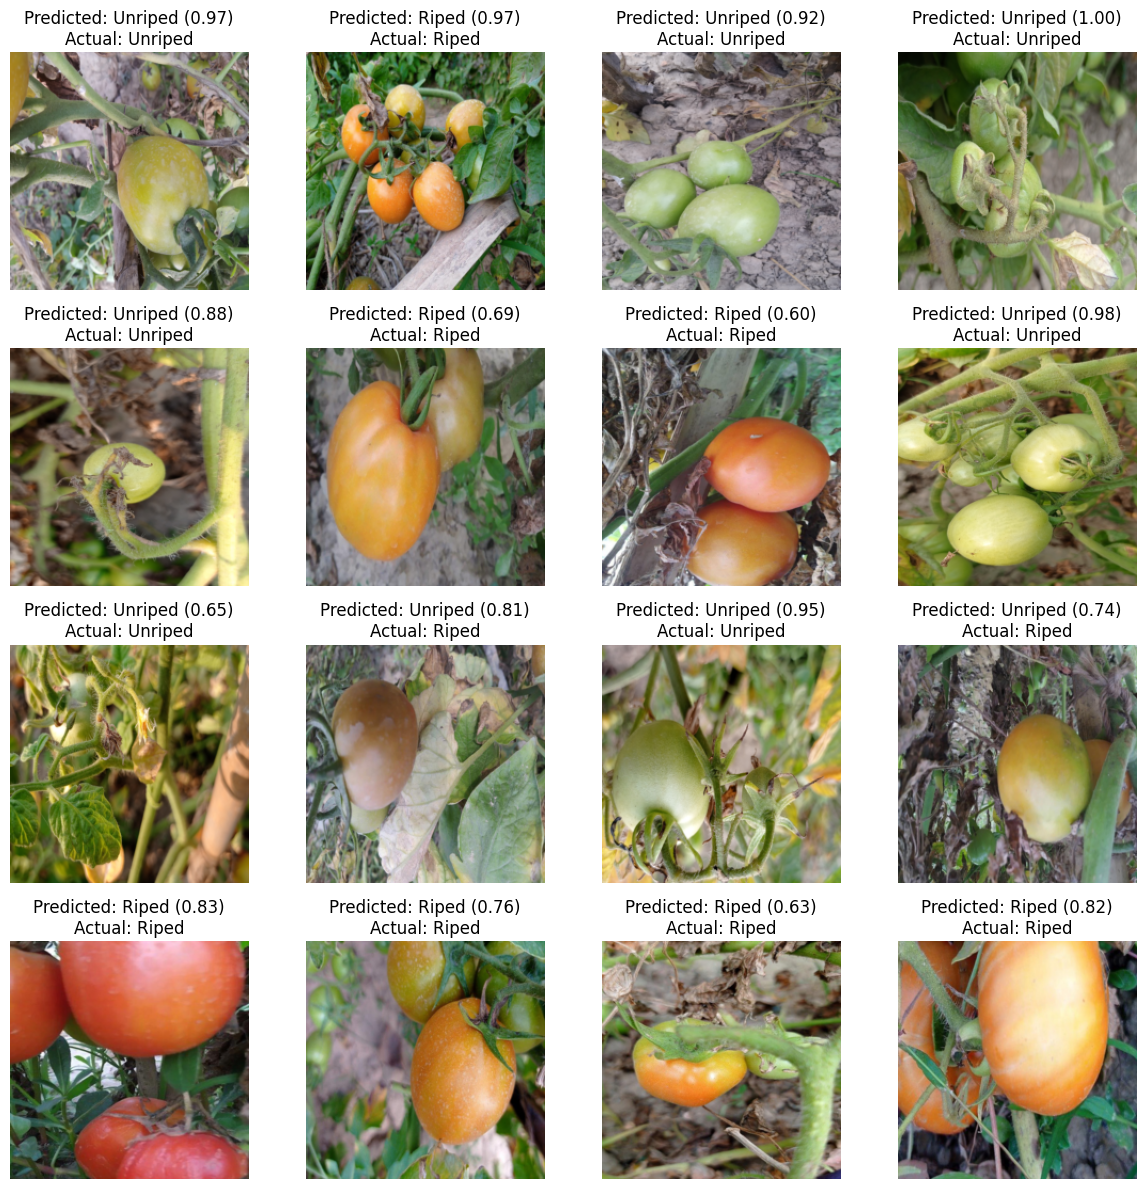

In [22]:
# Evaluate and display
evaluate_and_display(mean_teacher_model, validation_loader)